In [82]:
import math
from collections import defaultdict

import cv2
import matplotlib.pyplot as plt
import numpy as np

In [3]:
def threshold(image, val=0.0, reverse=False):
    h, w, ch = image.shape
    if ch > 1:
        image = np.mean(img, axis=2)

    if reverse:
        background = image[:, :] > val
    else:
        background = image[:, :] < val
        
    image[~background] = 255
    image[background] = 0

    return image

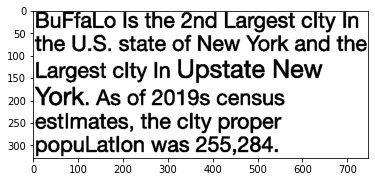

In [7]:
# apply Sauvola local adaptive thresholding
img = cv2.imread('data/test_img.jpg')
bin_img = threshold(img, np.mean(img)+10)
_ = plt.imshow(bin_img, cmap='gray')

libpng warning: iCCP: profile 'icc': 'RGB ': RGB color space not permitted on grayscale PNG


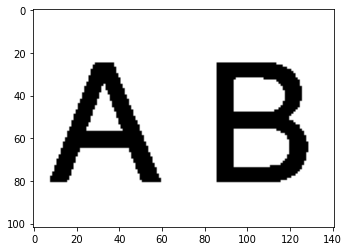

In [5]:
img = cv2.imread('2.png')
bin_img = threshold(img, np.mean(img)+10)
_ = plt.imshow(bin_img, cmap='gray')

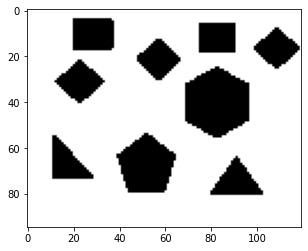

In [6]:
img = cv2.imread('n.png')
bin_img = threshold(img, np.mean(img)+10, reverse=True)
_ = plt.imshow(bin_img, cmap='gray')

In [117]:
np.unique(bin_img), bin_img.shape

(array([  0., 255.]), (396, 502))

In [141]:
FOREGROUND = 0.
BACKGROUND = 255.

def get_neighbours(k):
    neighbours = [
        [1, 0],
        [0, 1],
        [-1, 0],
        [0, -1],
    ]
    if k == 8:
        diag_neighbours = [
            [-1, -1],
            [1, 1],
            [-1, 1],
            [1, -1]
        ]
        neighbours += diag_neighbours

    return neighbours

def connected_components(arr, foreground, background, n_dir=8):
    arr = arr.copy()
    print(f'arr.shape : {arr.shape}')
    height, width = len(arr), len(arr[0])
    components = defaultdict(dict)
    visited = set()
    
    def dfs(i, j, p):
#         print(i, j, p)
        nonlocal height, width, arr, visited
        if i < 0 or i >= height or j < 0 or j >= width or arr[i][j] == -1 or (i, j) in visited:
            return
       
        visited.add((i, j))
        arr[i][j] = p
        neighbour_idx = get_neighbours(n_dir)
        for x, y in neighbour_idx:
            dfs(i+x, j+y, p)

                
    n_component = 1
    p = 1
    
    for i in range(height):
        for j in range(width):
            if arr[i][j] == background:
                arr[i][j] = -1
                
    print(np.unique(arr))
    
    for i in range(height):
        for j in range(width):
            if arr[i][j] == foreground:
                dfs(i, j, p)
                p += 1
                
    for i in range(height):
        for j in range(width):
            if arr[i][j] > 0:
                if i < components[arr[i][j]].get('left', float('inf')):
                    components[arr[i][j]]['left'] = i  
                if i > components[arr[i][j]].get('right', float('-inf')):
                    components[arr[i][j]]['right'] = i
                    
                if j < components[arr[i][j]].get('top', float('inf')):
                    components[arr[i][j]]['top'] = j  
                if j > components[arr[i][j]].get('bottom', float('-inf')):
                    components[arr[i][j]]['bottom'] = j
    
                
    return components
                

temp = connected_components(
    bin_img,
    foreground=0.,
    background=255.,
)
temp

arr.shape : (95, 120)
[-1.  0.]


defaultdict(dict,
            {1.0: {'left': 4, 'right': 17, 'top': 20, 'bottom': 37},
             2.0: {'left': 6, 'right': 18, 'top': 75, 'bottom': 90},
             3.0: {'left': 8, 'right': 25, 'top': 99, 'bottom': 118},
             4.0: {'left': 13, 'right': 30, 'top': 48, 'bottom': 66},
             5.0: {'left': 22, 'right': 40, 'top': 12, 'bottom': 33},
             6.0: {'left': 25, 'right': 55, 'top': 69, 'bottom': 96},
             7.0: {'left': 54, 'right': 79, 'top': 39, 'bottom': 64},
             8.0: {'left': 55, 'right': 73, 'top': 11, 'bottom': 28},
             9.0: {'left': 64, 'right': 80, 'top': 80, 'bottom': 102}})

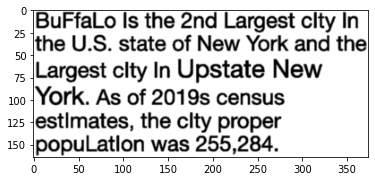

In [22]:
temp = cv2.pyrDown(bin_img)
_ = plt.imshow(temp, cmap='gray')

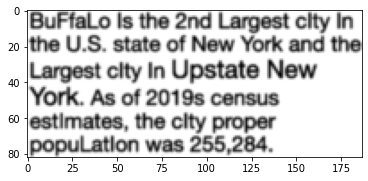

In [23]:
temp = cv2.pyrDown(temp)
_ = plt.imshow(temp, cmap='gray')

In [65]:
def gaussian_kernel(size, sigma):
    kernel_1d = np.linspace(- (size // 2), size // 2, size)
    gauss = np.exp(-0.5 * np.square(kernel_1d) / np.square(sigma))
    kernel_2d = np.outer(gauss, gauss)
    return kernel_2d / np.sum(kernel_2d)

In [151]:
def convolve(image, kernel, stride, padding=0):
    img_h, img_w = image.shape
    k_h, k_w = kernel.shape
    h = ((img_h - k_h + (2 * padding)) // stride) + 1
    w = ((img_w - k_w + (2 * padding)) // stride) + 1

    kernel = np.flipud(np.fliplr(kernel))
    output = []
    image = np.pad(image, pad_width=padding)

    for i in range(0, img_h-k_h+1, stride):
        for j in range(0, img_w-k_w+1, stride):
            region = image[i:i+k_h, j:j+k_w]
            output.append(np.multiply(region, kernel).sum())

    output = np.asarray(output)
    output = output.reshape(h, w)
    return output

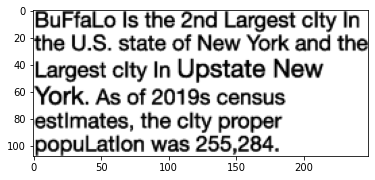

In [162]:
kernel = gaussian_kernel(size=5, sigma=1)
temp = convolve(bin_img, kernel, stride=3)
_ = plt.imshow(temp, cmap='gray')